In [46]:
import yaml
import os
import glob


from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader


import encoder
import transformer

# 결과

In [47]:
### data partition에 따른 xml path list를 load함.
def xml_path_loader(xml_folder, partition):
    xml_path = []
    for folder in os.listdir(xml_folder):
        for x in partition:
            if (x == folder):
                path = os.path.join(xml_folder, folder)
                xml_path.extend(glob.glob('{}/*.xml'.format(path)))
                xml_path.sort()

    return xml_path #list


### xml path를 이용하여 audio file 출력
def audio_path_loader(xml_path):
    filename = os.path.splitext(os.path.basename(xml_path))[0]
    audio_path = os.path.join(os.path.dirname(xml_path), 'v2', filename + '_1.wav')
    return audio_path

# audio 처리 관련 함수
# 함수 세 개 모두 dcase 참고
def pad_audio(audio, target_len, fs):
    
    if len(audio) < target_len:
        audio = torch.nn.functional.pad(
            audio, (0, target_len - audio.shape[-1]), mode="constant"
        )
        padded_indx = [target_len / len(audio)]
        onset_s = 0.000
    
    elif len(audio) > target_len:        # 여기를 수정함
        audio = audio[:target_len]
        onset_s = 0.000

        padded_indx = [target_len / len(audio)] 
    else:

        onset_s = 0.000
        padded_indx = [1.0]

    offset_s = round(onset_s + (target_len / fs), 3)
    return audio, onset_s, offset_s, padded_indx

def to_mono(mixture, random_ch=False):

    if mixture.ndim > 1:  # multi channel
        if not random_ch:
            mixture = torch.mean(mixture, 0)
        else:  # randomly select one channel
            indx = np.random.randint(0, mixture.shape[0] - 1)
            mixture = mixture[indx]
    return mixture

def read_audio(audio_path, pad_to, resample_rate):

    audio, sample_rate = torchaudio.load(audio_path)

    # downsampling(sample_rate : 32000 -> fs : 16000)
    if sample_rate != resample_rate:
        audio, sample_rate = resampler(audio, sample_rate, resample_rate) # audio_data = [channel, signal], channel = 1(mono)

    # multi src -> mono
    audio = to_mono(audio)

    audio_pad, _, _, _ = pad_audio(audio, pad_to, sample_rate)

    return audio_pad, sample_rate    

# Dataset configuration

class mivia(Dataset):
    def __init__(self, audio_folder, encoder, transform = None, target_transform = None, partition = ['A'], pad_to = 60, fs = 16000):
        self.audio_folder = audio_folder # xml_folder: audio_folder

        self.resample_rate = fs # resampling rate
        self.pad_to = pad_to * self.resample_rate # unit of pad_to : [second]

        self.encoder = encoder
        self.transform = transform
        self.target_transform = target_transform
        self.partition = partition

        self.xml_path = xml_path_loader(self.audio_folder, self.partition) # 모든 xml file의 directory를 load

    def __len__(self):
        return len(self.xml_path)  #len(xml_path) = 57

    def __getitem__(self, idx):

        target = self.encoder.encoder_strong_label(self.xml_path[idx]) # label load(xml file -> numpy)

        audio_path = audio_path_loader(self.xml_path[idx])
        audio_data, _ = read_audio(audio_path, self.pad_to, self.resample_rate) # data load, fs = 32000(default)

        if self.transform: #data transform
            # transform. use this function to extract features in dataloader
            spectrogram = self.transform
            audio_data = spectrogram(audio_data)

        return audio_data, target

### test code - custom dataset 짜기 전

In [48]:
directory = 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio'

In [49]:
# 별로 현명한 방법이 아니니 폐기하면 좋을 함수임.
# 아래 세 함수는 sort가 필요해서 사용 안했음.
def mivia_data_loader(audio_folder):
    audio_path_list = []
    xml_path_list = []
    for (path, dir, files) in os.walk(audio_folder): # dir : no use
        for filename in files:
            ext = os.path.splitext(filename)[-1]
            if ext == '.xml':
                xml_path_list.append(os.path.join(path, filename))
            elif ext == '.wav':
                audio_path_list.append(os.path.join(path, filename))
    
    return audio_path_list, xml_path_list


def xml_path_loader(xml_folder):
    xml_path = []
    filename = []
    for i in os.listdir(xml_folder):
        path = os.path.join(xml_folder, i)
        xml_path.extend(glob.glob('{}\\*.xml'.format(path)))

    return xml_path

    ###연습용
    xml_path = xml_path_loader(directory)
    print(xml.shape())
    print(len(xml_path))
    print(xml_path)
    ###

def audio_path_loader(audio_folder):
    audio_path = []
    for i in os.listdir(audio_folder):
        path = os.path.join(audio_folder, i)
        audio_path.extend(glob.glob('{}\\v2\\*.wav'.format(path)))

    return audio_path

# 혹시 모를 백업
# (audio_path, xml_path) = mivia_data_loader(directory)
# print(audio_path)
# print(xml_path)

# xml_path = xml_path_loader(directory)
# print(audio_path)
# print(xml_path)

# audio_path = audio_path_loader(directory)
# print(len(audio_path))
# print(audio_path)

### 여기서부터 audio file 처리

In [50]:
import torchaudio.transforms as transforms
import torchaudio
from transformer import *

#### yaml 읽기.

In [51]:
with open('..\\config\\default.yml') as f:
    conf = yaml.load(f, Loader = yaml.FullLoader)

In [52]:
print(conf['data']['select_valdata'])
print(conf['data']['select_testdata'])
print(conf['data']['select_traindata'])

for x in conf['data']['select_traindata']:
    print(x)
    print(type(x))

['B']
['A']
['C', 'D']
C
<class 'str'>
D
<class 'str'>


#### Audio 읽기 & transform test

In [53]:
test_audio = 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\D\\v2\\00043_1.wav'
# test_audio

sig, fs = torchaudio.load(test_audio)
sig_only = torchaudio.load(test_audio)[0]
print(sig_only.shape)
print(sig.shape)

spectrogram =  MelSpectrogram_transform(conf['feats'])

data = spectrogram(sig)
data.shape

torch.Size([1, 2040589])
torch.Size([1, 2040589])


torch.Size([1, 40, 7972])

### xml path loader 정의

In [10]:
### partition 도입 전 code. A~D partition에 속한 모든 xml file을 load 해줌

# def xml_path_loader(xml_folder):
#     xml_path = []
#     for folder in os.listdir(xml_folder):
#         path = os.path.join(xml_folder, folder)
#         xml_path.extend(glob.glob('{}\\*.xml'.format(path)))

#     return xml_path

###

### 위 code 실험용
# dir = 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio'
# xml = xml_path_loader(dir)
# print(xml)
# print(len(xml))
###

In [11]:
os.getcwd()

'z:\\nas1_data\\user\\hhj\\sound_event_detection\\utils'

### custom datset 설계
* xml_path_loader에서 해당 folder의 xml file 경로(directory)를 취함.
* audio_path_loader에서 xml file에 해당하는 audio file의 경로(directory)를 취함.

In [12]:
def xml_path_loader(xml_folder, partition):
    xml_path = []
    for folder in os.listdir(xml_folder):
        for x in partition:
            if (x == folder):
                path = os.path.join(xml_folder, folder)
                xml_path.extend(glob.glob('{}\\*.xml'.format(path)))

    return xml_path

In [17]:
import glob

In [39]:
dir = 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio'
xml_path = []
for folder in os.listdir(dir):
    for x in ['A']:
        if (x == folder):
            path = os.path.join(dir, folder)
            xml_path.extend(glob.glob('{}\\*.xml'.format(path)))
            xml_path.sort()
        break
print(xml_path)
# a = os.path.splitext(xml_path[0])[0]
# print(a)
# print(a.split('\\')[-1])

['z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\A\\00001.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\A\\00002.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\A\\00003.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\A\\00004.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\A\\00005.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\A\\00006.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\A\\00007.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\A\\00008.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\A\\00009.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\A\\00010.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\A\\00011.xml', 'z:\\nas1_data\\user

In [13]:
dir = 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio'
xml = xml_path_loader(dir, conf['data']['select_traindata'])
print(xml)
print(len(xml))


['z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\D\\00047.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\D\\00046.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\D\\00045.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\D\\00044.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\D\\00043.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\D\\00057.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\D\\00056.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\D\\00055.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\D\\00054.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\D\\00053.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\D\\00052.xml', 'z:\\nas1_data\\user

In [14]:
xml = xml_path_loader(dir, conf['data']['select_valdata'])
print(xml)
print(len(xml))


['z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\B\\00027.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\B\\00016.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\B\\00020.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\B\\00019.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\B\\00024.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\B\\00017.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\B\\00021.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\B\\00025.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\B\\00028.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\B\\00022.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\B\\00026.xml', 'z:\\nas1_data\\user

In [15]:
xml = xml_path_loader(dir, conf['data']['select_testdata'])
print(xml)
print(len(xml))


['z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\A\\00012.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\A\\00007.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\A\\00013.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\A\\00004.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\A\\00001.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\A\\00005.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\A\\00010.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\A\\00008.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\A\\00002.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\A\\00014.xml', 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\A\\00006.xml', 'z:\\nas1_data\\user

### audio path loader 정의

In [16]:
### xml path를 이용하여 audio file 출력
def audio_path_loader(xml_path):
    filename = os.path.splitext(os.path.basename(xml_path))[0]
    audio_path = os.path.join(os.path.dirname(xml_path), 'v2', filename + '_1.wav')
    return audio_path

### audio_path_loader test

In [17]:
for x in xml:
    audio_path = audio_path_loader(x)
    print(x, audio_path)

z:\nas1_data\user\hhj\sound_event_detection\data\mivia_raw\audio\A\00012.xml z:\nas1_data\user\hhj\sound_event_detection\data\mivia_raw\audio\A\v2\00012_1.wav
z:\nas1_data\user\hhj\sound_event_detection\data\mivia_raw\audio\A\00007.xml z:\nas1_data\user\hhj\sound_event_detection\data\mivia_raw\audio\A\v2\00007_1.wav
z:\nas1_data\user\hhj\sound_event_detection\data\mivia_raw\audio\A\00013.xml z:\nas1_data\user\hhj\sound_event_detection\data\mivia_raw\audio\A\v2\00013_1.wav
z:\nas1_data\user\hhj\sound_event_detection\data\mivia_raw\audio\A\00004.xml z:\nas1_data\user\hhj\sound_event_detection\data\mivia_raw\audio\A\v2\00004_1.wav
z:\nas1_data\user\hhj\sound_event_detection\data\mivia_raw\audio\A\00001.xml z:\nas1_data\user\hhj\sound_event_detection\data\mivia_raw\audio\A\v2\00001_1.wav
z:\nas1_data\user\hhj\sound_event_detection\data\mivia_raw\audio\A\00005.xml z:\nas1_data\user\hhj\sound_event_detection\data\mivia_raw\audio\A\v2\00005_1.wav
z:\nas1_data\user\hhj\sound_event_detection\da

# custom dataset <최종 code>

In [18]:
### data partition에 따른 xml path list를 load함.
def xml_path_loader(xml_folder, partition):
    xml_path = []
    for folder in os.listdir(xml_folder):
        for x in partition:
            if (x == folder):
                path = os.path.join(xml_folder, folder)
                xml_path.extend(glob.glob('{}/*.xml'.format(path)))

    return xml_path #list


### xml path를 이용하여 audio file 출력
def audio_path_loader(xml_path):
    filename = os.path.splitext(os.path.basename(xml_path))[0]
    audio_path = os.path.join(os.path.dirname(xml_path), 'v2', filename + '_1.wav')
    return audio_path

# audio 처리 관련 함수
# 함수 세 개 모두 dcase 참고
def pad_audio(audio, target_len, fs):
    
    if len(audio) < target_len:
        audio = torch.nn.functional.pad(
            audio, (0, target_len - audio.shape[-1]), mode="constant"
        )
        padded_indx = [target_len / len(audio)]
        onset_s = 0.000
    
    elif len(audio) > target_len:        # 여기를 수정함
        audio = audio[:target_len]
        onset_s = 0.000

        padded_indx = [target_len / len(audio)] 
    else:

        onset_s = 0.000
        padded_indx = [1.0]

    offset_s = round(onset_s + (target_len / fs), 3)
    return audio, onset_s, offset_s, padded_indx

def to_mono(mixture, random_ch=False):

    if mixture.ndim > 1:  # multi channel
        if not random_ch:
            mixture = torch.mean(mixture, 0)
        else:  # randomly select one channel
            indx = np.random.randint(0, mixture.shape[0] - 1)
            mixture = mixture[indx]
    return mixture

def read_audio(audio_path, pad_to, resample_rate):

    audio, sample_rate = torchaudio.load(audio_path)

    # downsampling(sample_rate : 32000 -> fs : 16000)
    if sample_rate != resample_rate:
        audio, sample_rate = resampler(audio, sample_rate, resample_rate) # audio_data = [channel, signal], channel = 1(mono)

    # multi src -> mono
    audio = to_mono(audio)

    audio_pad, _, _, _ = pad_audio(audio, pad_to, sample_rate)

    return audio_pad, sample_rate    

# Dataset configuration

class mivia(Dataset):
    def __init__(self, audio_folder, encoder, transform = None, target_transform = None, partition = ['A'], pad_to = 60, fs = 16000):
        self.audio_folder = audio_folder # xml_folder: audio_folder

        self.resample_rate = fs # resampling rate
        self.pad_to = pad_to * self.resample_rate # unit of pad_to : [second]

        self.encoder = encoder
        self.transform = transform
        self.target_transform = target_transform
        self.partition = partition

        self.xml_path = xml_path_loader(self.audio_folder, self.partition) # 모든 xml file의 directory를 load

    def __len__(self):
        return len(self.xml_path)  #len(xml_path) = 57

    def __getitem__(self, idx):

        target = self.encoder.encoder_strong_label(self.xml_path[idx]) # label load(xml file -> numpy)

        audio_path = audio_path_loader(self.xml_path[idx])
        audio_data, _ = read_audio(audio_path, self.pad_to, self.resample_rate) # data load, fs = 32000(default)

        if self.transform: #data transform
            # transform. use this function to extract features in dataloader
            spectrogram = self.transform
            audio_data = spectrogram(audio_data)

        return audio_data, target

### 동작 Test code 1. 
* dataset에서 data가 잘 load되는지

In [19]:
with open('..\\config\\default.yml') as f:
    conf = yaml.load(f, Loader = yaml.FullLoader)

In [20]:
encoder = multi_label_encoder(
    fs = conf['feats']['sample_rate'], 
    audio_len = conf['feats']['audio_len'], 
    n_fft = conf['feats']['n_fft'], 
    hop_length = conf['feats']['hop_length'], 
    net_pooling = conf['feats']['net_pooling']
    )

training_data = mivia(
    conf['data']['audio_folder'], 
    encoder = encoder,
    transform = MelSpectrogram_transform(conf['feats']),
    target_transform= None, 
    partition = conf['data']['select_traindata'], 
    pad_to = conf['feats']['audio_len'],
    fs = conf['feats']['sample_rate']
    )

test_data = mivia(
    conf['data']['audio_folder'], 
    encoder = encoder,
    transform = MelSpectrogram_transform(conf['feats']),
    target_transform= None, 
    partition = conf['data']['select_testdata'], 
    pad_to = conf['feats']['audio_len'],
    fs = conf['feats']['sample_rate']
    )

validation_data = mivia(
    conf['data']['audio_folder'], 
    encoder = encoder,
    transform = MelSpectrogram_transform(conf['feats']),
    target_transform= None, 
    partition = conf['data']['select_valdata'], 
    pad_to = conf['feats']['audio_len'],
    fs = conf['feats']['sample_rate']
    )
# test_data = mivia(conf['data']['audio_folder'], conf['data']['xml_folder'], encoder, partition = conf['data']['select_testdata'], transform = MelSpectrogram_transform(conf['feats']))

In [21]:
training_data_iter = iter(training_data)
audio, target = next(training_data_iter)

In [22]:
print(audio.shape) # mel spectrogram
print(target.shape)

torch.Size([40, 3751])
(3750, 3)


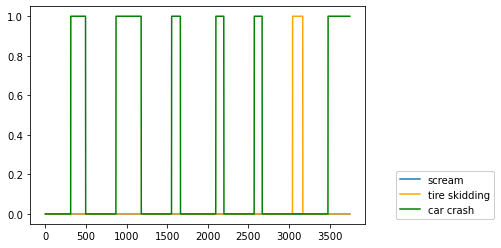

In [23]:
matplotlib_label_show(target)

In [24]:
audio, target = next(training_data_iter)
print(audio.shape)
print(target.shape)


torch.Size([40, 3751])
(3750, 3)


### 동작 Test 2. dataloader 적용

In [25]:
encoder = multi_label_encoder(
    fs = conf['feats']['sample_rate'], 
    audio_len = conf['feats']['audio_len'], 
    n_fft = conf['feats']['n_fft'], 
    hop_length = conf['feats']['hop_length'], 
    net_pooling = conf['feats']['net_pooling']
    )

training_data = mivia(
    conf['data']['audio_folder'], 
    encoder = encoder,
    transform = MelSpectrogram_transform(conf['feats']),
    target_transform= None, 
    partition = conf['data']['select_traindata'], 
    pad_to = conf['feats']['audio_len'],
    fs = conf['feats']['sample_rate']
    )

test_data = mivia(
    conf['data']['audio_folder'], 
    encoder = encoder,
    transform = MelSpectrogram_transform(conf['feats']),
    target_transform= None, 
    partition = conf['data']['select_testdata'], 
    pad_to = conf['feats']['audio_len'],
    fs = conf['feats']['sample_rate']
    )

validation_data = mivia(
    conf['data']['audio_folder'], 
    encoder = encoder,
    transform = MelSpectrogram_transform(conf['feats']),
    target_transform= None, 
    partition = conf['data']['select_valdata'], 
    pad_to = conf['feats']['audio_len'],
    fs = conf['feats']['sample_rate']
    )
# test_data = mivia(conf['data']['audio_folder'], conf['data']['xml_folder'], encoder, partition = conf['data']['select_testdata'], transform = MelSpectrogram_transform(conf['feats']))

### dataset의 size 구하기

In [52]:
print(len(training_data))
print(len(test_data))
print(len(validation_data))

29
14
14


### dataset의 size 구하기 & batch num 구하기

In [59]:
train_dataloader = DataLoader(training_data, batch_size = 4)
test_dataloader = DataLoader(test_data, batch_size = 2)
validation_dataloader = DataLoader(validation_data, batch_size = 2)
# size
print(len(train_dataloader.dataset), len(test_dataloader.dataset), len(validation_dataloader.dataset))
# batch num
print(len(train_dataloader), len(test_dataloader), len(validation_dataloader))
# batch num 직접 계산
print(np.ceil(len(training_data) / 4))
print(np.ceil(len(test_data) / 2))
print(np.ceil(len(validation_data) / 2))

29 14 14
8 7 7
8.0
7.0
7.0


In [28]:
audio, target = next(iter(train_dataloader))
print(audio.shape)
print(target.shape)

audio_trans = audio.transpose(1, 2).unsqueeze(1)
print(audio_trans.shape)

torch.Size([4, 40, 3751])
torch.Size([4, 3750, 3])
torch.Size([4, 1, 3751, 40])


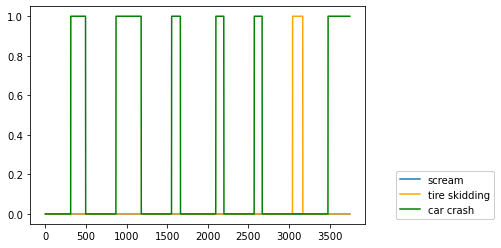

In [29]:
matplotlib_label_show(target[0,:,:])

Shape: (40, 3751)
Dtype: torch.float32
 - Max:     291.912
 - Min:      0.001
 - Mean:     7.975
 - Std Dev: 16.898

tensor([[2.1342e-03, 2.8545e-03, 4.0992e-03,  ..., 1.4015e+00, 1.3697e+00,
         1.2630e+00],
        [4.1498e-03, 4.3718e-03, 4.2053e-03,  ..., 3.7505e+00, 3.0626e+00,
         2.3119e+00],
        [4.0589e-03, 4.4085e-03, 4.3279e-03,  ..., 4.3601e+00, 4.3484e+00,
         4.0556e+00],
        ...,
        [8.8946e-03, 9.3681e-03, 9.0700e-03,  ..., 9.6848e+00, 7.9640e+00,
         7.1861e+00],
        [4.5439e-03, 4.7596e-03, 4.5960e-03,  ..., 4.7682e+00, 3.8765e+00,
         3.2815e+00],
        [1.4586e-03, 1.3909e-03, 1.1392e-03,  ..., 8.3394e-01, 7.4458e-01,
         6.9691e-01]])



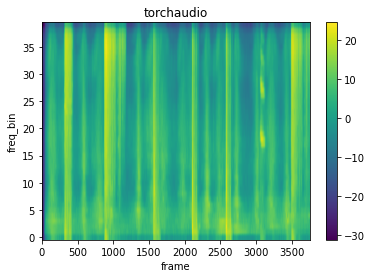

In [30]:
from transformer import *
print_stats(audio[0,:,:])
plot_spectrogram(audio[0,:,:], title='torchaudio')

In [31]:
for batch_ndx, sample in enumerate(train_dataloader, 0):
    print(batch_ndx)
    print(sample[0].shape) # audio [batch_size, channel, mel_freq, time_axis]
    print(sample[1].shape) # target [batch_size, segment, class]

    

0
torch.Size([4, 40, 3751])
torch.Size([4, 3750, 3])
1
torch.Size([4, 40, 3751])
torch.Size([4, 3750, 3])
2
torch.Size([4, 40, 3751])
torch.Size([4, 3750, 3])
3
torch.Size([4, 40, 3751])
torch.Size([4, 3750, 3])
4
torch.Size([4, 40, 3751])
torch.Size([4, 3750, 3])
5
torch.Size([4, 40, 3751])
torch.Size([4, 3750, 3])
6
torch.Size([4, 40, 3751])
torch.Size([4, 3750, 3])
7
torch.Size([1, 40, 3751])
torch.Size([1, 3750, 3])


In [32]:
print(len(train_dataloader.dataset))

29


In [33]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
# img = train_features[0].squeeze()
label = train_labels[0]
# plt.imshow(img, cmap="gray")
# plt.show()
print(f"Label: {label}")

Feature batch shape: torch.Size([4, 40, 3751])
Labels batch shape: torch.Size([4, 3750, 3])
Label: tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]])


In [51]:
for i, data in enumerate(train_dataloader, 0):
    print(i, data[0].shape, data[1].shape)

0 torch.Size([4, 40, 3751]) torch.Size([4, 3750, 3])
1 torch.Size([4, 40, 3751]) torch.Size([4, 3750, 3])
2 torch.Size([4, 40, 3751]) torch.Size([4, 3750, 3])
3 torch.Size([4, 40, 3751]) torch.Size([4, 3750, 3])
4 torch.Size([4, 40, 3751]) torch.Size([4, 3750, 3])
5 torch.Size([4, 40, 3751]) torch.Size([4, 3750, 3])
6 torch.Size([4, 40, 3751]) torch.Size([4, 3750, 3])
7 torch.Size([1, 40, 3751]) torch.Size([1, 3750, 3])


### reference code 모음(audio padding). lsh collate code
* 참고용
* 링크 : https://github.com/seunghyeon528/Extract_PASE_Features/blob/main/extract_PASE_feature.py

In [35]:
def my_collate(batch):
    audios,save_paths = list(zip(*batch))
    # find max length of audios in batch
    audios_len = torch.LongTensor(np.array([x.shape[1] for x in audios]))
    max_len = max(audios_len)

    # zero padding
    batch_size = len(audios)
    inputs = torch.zeros(batch_size,1,max_len)
    for i in range(batch_size):
        inputs[i,:, :audios[i].shape[1]] = audios[i]

    return (inputs, save_paths, audios_len)

##### 1번 test code

In [36]:
test_audio = 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\D\\v2\\00047_1.wav'
sig, fs = torchaudio.load(test_audio)

In [37]:
import numpy as np
import torch

audio_1 = torch.arange(10, dtype = float)
audio_2 = torch.arange(9, dtype = float)
audio_3 = torch.arange(12, dtype = float)

In [38]:
print(audio_1.shape)
audio = [audio_1, audio_2, audio_3]
a = [x.shape for x in audio]
print(a)

torch.Size([10])
[torch.Size([10]), torch.Size([9]), torch.Size([12])]


In [39]:
audio_len = np.array([x.shape[0] for x in audio]) #
print(audio_len)
print(audio[0].shape[0])

[10  9 12]
10


In [40]:
audio_len = torch.LongTensor(audio_len)
print(audio_len)
max_len = max(audio_len)
print(max_len)

tensor([10,  9, 12])
tensor(12)


In [41]:
batch_size = len(audio)
print(batch_size)

3


In [42]:
inputs = torch.zeros(batch_size,1,max_len)
print(inputs.shape)

torch.Size([3, 1, 12])


In [43]:
for i in range(batch_size):
    inputs[i,:, :audio[i].shape[0]] = audio[i]

In [44]:
print(audio)
print(inputs)

[tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], dtype=torch.float64), tensor([0., 1., 2., 3., 4., 5., 6., 7., 8.], dtype=torch.float64), tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.],
       dtype=torch.float64)]
tensor([[[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.,  0.,  0.]],

        [[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  0.,  0.,  0.]],

        [[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.]]])


#### 2. dcase pad_audio code
* 참고용
* 링크 : https://github.com/DCASE-REPO/DESED_task/blob/ffb3d49feb740da789fff80c082bdde6b98e7cb4/desed_task/dataio/datasets.py#L116

In [45]:
import random
def pad_audio(audio, target_len, fs):
    
    if audio.shape[-1] < target_len:
        audio = torch.nn.functional.pad(
            audio, (0, target_len - audio.shape[-1]), mode="constant"
        )

        padded_indx = [target_len / len(audio)]
        onset_s = 0.000
    
    elif len(audio) > target_len:
        
        rand_onset = random.randint(0, len(audio) - target_len)
        audio = audio[rand_onset:rand_onset + target_len]
        onset_s = round(rand_onset / fs, 3)

        padded_indx = [target_len / len(audio)] 
    else:

        onset_s = 0.000
        padded_indx = [1.0]

    offset_s = round(onset_s + (target_len / fs), 3)
    return audio, onset_s, offset_s, padded_indx

##### 2번 test code

In [46]:
test_audio = 'z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\D\\v2\\00047_1.wav'
sig, fs = torchaudio.load(test_audio)
audio_1 = torch.arange(10, dtype = float)
audio_2 = torch.arange(9, dtype = float)
audio_3 = torch.arange(12, dtype = float)

In [47]:
sig_pad = pad_audio(audio_1, 15, )

TypeError: pad_audio() missing 1 required positional argument: 'fs'

#### 3.FilterAugSED pad audio code
* 참고용
* 링크 : https://github.com/frednam93/FilterAugSED/blob/main/utils/dataset.py

In [ ]:
def pad_wav(wav, pad_to, encoder):
    if len(wav) < pad_to:
        pad_from = len(wav)
        wav = np.pad(wav, (0, pad_to - len(wav)), mode="constant")
    else:
        wav = wav[:pad_to]
        pad_from = pad_to
    pad_idx = np.ceil(encoder._time_to_frame(pad_from / encoder.sr))
    pad_mask = torch.arange(encoder.n_frames) >= pad_idx # size = n_frame, [0, 0, 0, 0, 0, ..., 0, 1, ..., 1]
    return wav, pad_mask

## (중요) pad audio code 추가
* 아래 세 함수를 위 dataset 최종에 추가함.
### 동작 Test 3. audio padding
* audio length 조절


### pad_audio test # 1
* audio file로 test

In [ ]:
# audio 처리 관련 함수
# 함수 세 개 모두 dcase 참고
def pad_audio(audio, target_len, fs):
    
    if len(audio) < target_len:
        audio = torch.nn.functional.pad(
            audio, (0, target_len - audio.shape[-1]), mode="constant"
        )
        padded_indx = [target_len / len(audio)]
        onset_s = 0.000
    
    elif len(audio) > target_len:        # 여기를 수정함
        audio = audio[:target_len]
        onset_s = 0.000

        padded_indx = [target_len / len(audio)] 
    else:

        onset_s = 0.000
        padded_indx = [1.0]

    offset_s = round(onset_s + (target_len / fs), 3)
    return audio, onset_s, offset_s, padded_indx

def to_mono(mixture, random_ch=False):

    if mixture.ndim > 1:  # multi channel
        if not random_ch:
            mixture = torch.mean(mixture, 0)
        else:  # randomly select one channel
            indx = np.random.randint(0, mixture.shape[0] - 1)
            mixture = mixture[indx]
    return mixture

def read_audio(audio_path, pad_to, resample_rate):

    audio, sample_rate = torchaudio.load(audio_path)

    # downsampling(sample_rate : 32000 -> fs : 16000)
    if sample_rate != resample_rate:
        audio, sample_rate = resampler(audio, sample_rate, resample_rate) # audio_data = [channel, signal], channel = 1(mono)

    # multi src -> mono
    audio = to_mono(audio)

    audio_pad, _, _, _ = pad_audio(audio, pad_to, sample_rate)

    return audio_pad, sample_rate    

In [ ]:
# original audio load
print("-----original audio load-----")
audio_origin, fs = torchaudio.load('z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\D\\v2\\00043_1.wav')
print(type(audio_origin))
print(audio_origin.shape, fs)
# resample test
print("-----resample test-----")

audio_resample, fs_re = resampler(audio_origin, fs, 16000)
print(type(audio_resample))
print(audio_resample.shape, fs_re)

# to mono test
print("-----mono test-----")
audio_mono = to_mono(audio_resample)
print(type(audio_mono))
print(audio_mono.shape)

# pad test
print("-----pad test-----")
audio_pad, _, _, _ = pad_audio(audio_mono, 960000, fs_re)
print(type(audio_pad))
print(audio_pad.shape)

-----original audio load-----
<class 'torch.Tensor'>
torch.Size([1, 2040589]) 32000
-----resample test-----
<class 'torch.Tensor'>
torch.Size([1, 1020295]) 16000
-----mono test-----
<class 'torch.Tensor'>
torch.Size([1020295])
-----pad test-----
<class 'torch.Tensor'>
torch.Size([960000])


In [ ]:
print(torch.equal(audio_mono[:960000], audio_pad))
print(audio_mono[:96000])

True
tensor([ 1.1863e-06, -8.1851e-06,  4.7717e-06,  ..., -8.6929e-03,
        -8.1910e-03, -1.0293e-02])


In [ ]:
audio_read_output, fs_read_audio = read_audio('z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\D\\v2\\00043_1.wav', 960000, 16000)
print(torch.equal(audio_pad, audio_read_output))
print(torch.equal(audio_mono[:960000], audio_read_output))

True
True


### pad audio test #2
* 직접 값 넣어서 test

In [ ]:
audio_1 = torch.arange(10, dtype = float)
audio_2 = torch.arange(9, dtype = float)
audio_3 = torch.arange(12, dtype = float)

* resample 없이 test

In [ ]:
print("-----mono test-----")
audio_mono = to_mono(audio_1)
print(audio_1)
print(audio_mono)
print(type(audio_mono))
print(audio_mono.shape)
print("-----pad test-----")
audio_pad, _, _, _ = pad_audio(audio_mono, 15, fs_re)
print(type(audio_pad))
print(audio_pad.shape)
print(audio_pad)

-----mono test-----
tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], dtype=torch.float64)
tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], dtype=torch.float64)
<class 'torch.Tensor'>
torch.Size([10])
-----pad test-----
<class 'torch.Tensor'>
torch.Size([15])
tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 0., 0., 0., 0., 0.],
       dtype=torch.float64)


In [ ]:
print("-----mono test-----")
audio_mono = to_mono(audio_2)
print(audio_2)
print(audio_mono)
print(type(audio_mono))
print(audio_mono.shape)
print("-----pad test-----")
audio_pad, _, _, _ = pad_audio(audio_mono, 5, fs_re)
print(type(audio_pad))
print(audio_pad.shape)
print(audio_pad)

-----mono test-----
tensor([0., 1., 2., 3., 4., 5., 6., 7., 8.], dtype=torch.float64)
tensor([0., 1., 2., 3., 4., 5., 6., 7., 8.], dtype=torch.float64)
<class 'torch.Tensor'>
torch.Size([9])
-----pad test-----
<class 'torch.Tensor'>
torch.Size([5])
tensor([0., 1., 2., 3., 4.], dtype=torch.float64)


In [ ]:
print("-----mono test-----")
audio_mono = to_mono(audio_3)
print(audio_3)
print(audio_mono)
print(type(audio_mono))
print(audio_mono.shape)
print("-----pad test-----")
audio_pad, _, _, _ = pad_audio(audio_mono, 15, fs_re)
print(type(audio_pad))
print(audio_pad.shape)
print(audio_pad)

-----mono test-----
tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.],
       dtype=torch.float64)
tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.],
       dtype=torch.float64)
<class 'torch.Tensor'>
torch.Size([12])
-----pad test-----
<class 'torch.Tensor'>
torch.Size([15])
tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.,  0.,  0.,
         0.], dtype=torch.float64)


* resample 있이 test

In [ ]:
# original audio load
print("-----original audio load-----")
audio_origin, fs = audio_1, 10
print(type(audio_origin))
print(audio_origin.shape, fs)
print(audio_origin)
# resample test
print("-----resample test-----")

audio_resample, fs_re = resampler(audio_origin, fs, 5)
print(type(audio_resample))
print(audio_resample.shape, fs_re)
print(audio_resample)

# to mono test
print("-----mono test-----")
audio_mono = to_mono(audio_resample)
print(type(audio_mono))
print(audio_mono.shape)

# pad test
print("-----pad test-----")
audio_pad, _, _, _ = pad_audio(audio_mono, 15, fs_re)
print(type(audio_pad))
print(audio_pad.shape)
print(audio_pad)

-----original audio load-----
<class 'torch.Tensor'>
torch.Size([10]) 10
tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], dtype=torch.float64)
-----resample test-----
<class 'torch.Tensor'>
torch.Size([5]) 5
tensor([4.6141e-03, 2.1730e+00, 3.8235e+00, 6.0668e+00, 8.2933e+00],
       dtype=torch.float64)
-----mono test-----
<class 'torch.Tensor'>
torch.Size([5])
-----pad test-----
<class 'torch.Tensor'>
torch.Size([15])
tensor([4.6141e-03, 2.1730e+00, 3.8235e+00, 6.0668e+00, 8.2933e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00], dtype=torch.float64)


In [ ]:
# original audio load
print("-----original audio load-----")
audio_origin, fs = audio_2, 10
print(type(audio_origin))
print(audio_origin.shape, fs)
# resample test
print("-----resample test-----")

audio_resample, fs_re = resampler(audio_origin, fs, 5)
print(type(audio_resample))
print(audio_resample.shape, fs_re)

# to mono test
print("-----mono test-----")
audio_mono = to_mono(audio_resample)
print(type(audio_mono))
print(audio_mono.shape)

# pad test
print("-----pad test-----")
audio_pad, _, _, _ = pad_audio(audio_mono, 15, fs_re)
print(type(audio_pad))
print(audio_pad.shape)
print(audio_pad)

-----original audio load-----
<class 'torch.Tensor'>
torch.Size([9]) 10
-----resample test-----
<class 'torch.Tensor'>
torch.Size([5]) 5
-----mono test-----
<class 'torch.Tensor'>
torch.Size([5])
-----pad test-----
<class 'torch.Tensor'>
torch.Size([15])
tensor([0.1364, 2.1451, 3.6193, 6.7747, 5.5155, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000], dtype=torch.float64)


### 동작 test 4. transformer 검증

In [ ]:
from transformer import *

In [ ]:
training_data = mivia(conf['data']['audio_folder'], conf['data']['xml_folder'], encoder, partition = conf['data']['select_traindata'], transform = MelSpectrogram_transform(conf['feats']))
print(len(training_data))

29


In [ ]:
training_data_iter = iter(training_data)
audio, target = next(training_data_iter)

z:\nas1_data\user\hhj\sound_event_detection\data\mivia_raw\audio\D\00047.xml


torch.Size([40, 3751])
Shape: (40, 3751)
Dtype: torch.float32
 - Max:     291.912
 - Min:      0.001
 - Mean:     7.975
 - Std Dev: 16.898

tensor([[2.1342e-03, 2.8545e-03, 4.0992e-03,  ..., 1.4015e+00, 1.3697e+00,
         1.2630e+00],
        [4.1498e-03, 4.3718e-03, 4.2053e-03,  ..., 3.7505e+00, 3.0626e+00,
         2.3119e+00],
        [4.0589e-03, 4.4085e-03, 4.3279e-03,  ..., 4.3601e+00, 4.3484e+00,
         4.0556e+00],
        ...,
        [8.8946e-03, 9.3681e-03, 9.0700e-03,  ..., 9.6848e+00, 7.9640e+00,
         7.1861e+00],
        [4.5439e-03, 4.7596e-03, 4.5960e-03,  ..., 4.7682e+00, 3.8765e+00,
         3.2815e+00],
        [1.4586e-03, 1.3909e-03, 1.1392e-03,  ..., 8.3394e-01, 7.4458e-01,
         6.9691e-01]])



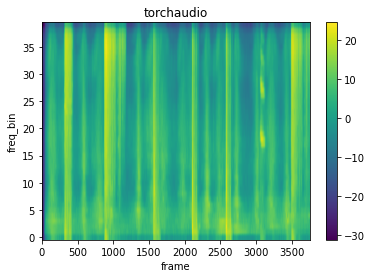

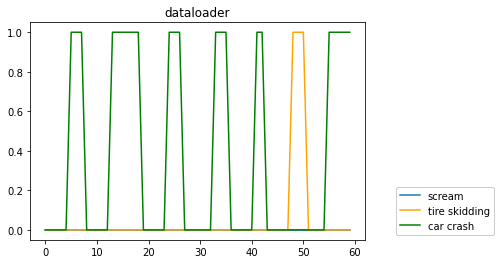

In [ ]:
print(audio.shape) # dir : z:\nas1_data\user\hhj\sound_event_detection\data\mivia_raw\audio\D\00047.xml

print_stats(audio)
plot_spectrogram(audio, title='torchaudio')
matplotlib_label_show(target, 'dataloader')

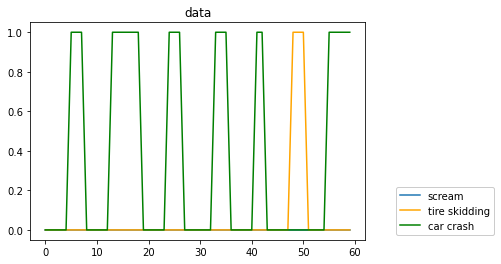

In [ ]:
target_test = encoder.encoder_strong_label('z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\D\\00047.xml')
matplotlib_label_show(target_test, 'data')

z:\nas1_data\user\hhj\sound_event_detection\data\mivia_raw\audio\D\00045.xml
torch.Size([40, 3751])
Shape: (40, 3751)
Dtype: torch.float32
 - Max:     745.515
 - Min:      0.003
 - Mean:     9.037
 - Std Dev: 19.416

tensor([[ 1.1929,  1.2983,  1.3901,  ..., 15.2198, 15.1362, 14.6149],
        [ 0.1753,  0.2520,  0.3537,  ...,  9.5176,  9.0985,  8.9162],
        [ 0.1122,  0.1732,  0.2438,  ..., 10.9584, 10.6551, 10.5180],
        ...,
        [ 0.2944,  0.2548,  0.1593,  ...,  1.4632,  1.4305,  1.3197],
        [ 0.3459,  0.2993,  0.1870,  ...,  0.6269,  0.6225,  0.5797],
        [ 0.3521,  0.3046,  0.1903,  ...,  0.1570,  0.1847,  0.1554]])



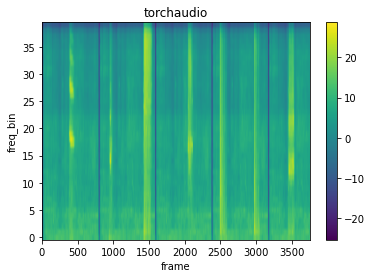

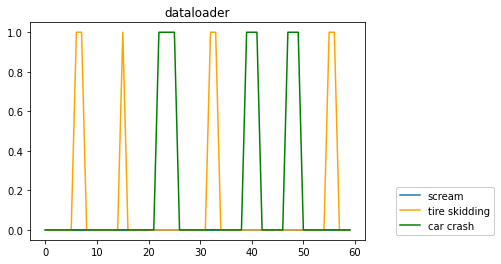

In [ ]:
audio, target = next(training_data_iter)
print(audio.shape) # dir : z:\nas1_data\user\hhj\sound_event_detection\data\mivia_raw\audio\D\00045.xml

print_stats(audio)
plot_spectrogram(audio, title='torchaudio')
matplotlib_label_show(target, 'dataloader')

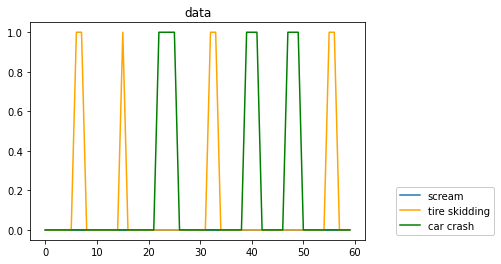

In [ ]:
target_test = encoder.encoder_strong_label('z:\\nas1_data\\user\\hhj\\sound_event_detection\\data\\mivia_raw\\audio\\D\\00045.xml')
matplotlib_label_show(target_test, 'data')